# Tweets - Analysis

In [1]:
import configparser
import csv
import itertools
import json
import operator
from os import listdir
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import plotly.plotly as py
import seaborn as sns
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

from _helpers import *

tqdm.pandas()

In [2]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=2)

## File directories

In [8]:
root = Path('../../')
Config = configparser.ConfigParser()
Config.read(str(root / 'config.cnf'))

tweets = root / Config.get('output_files', 'tweets')
tweets = load_tweets(tweets)

queries = root / Config.get('input_files', 'queries')
queries = load_queries(str(queries))

summary_tweets = root / Config.get('output_files', 'summary_tweets')

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [11]:
tweets.venue.unique().tolist()

['slate',
 'iflscience',
 'washingtonpost',
 'bostonglobe',
 'chicago',
 'foxnews',
 'sfchronicle',
 'nytimes',
 'latimes',
 'theglobeandmail',
 'wired',
 'theguardian']

In [16]:
t = tweets.shape[0]

x = tweets[tweets.error.isna()].refetched.sum()
print("Successfully refetched {} ({:.2f}%) tweets".format(x, 100*x/t))

x = tweets.error.count()
y = tweets[tweets.error.isna()].is_truncated.sum()
print("{} ({:.2f}%) failed to refetch. All tweets with refetch errors are removed from the dataset.\n{} tweets remain truncated.\n".format(x, 100*x/t, y))
print("Error Breakdown")
for x,y in tweets.error.value_counts().iteritems():
    x = eval(x)
    print("{} ({}): {}".format(x[0]['message'], x[0]['code'], y))

# Remove tweets that failed to refetch
tweets = tweets[tweets.error.isna()]

Successfully refetched 48350 (1.35%) tweets
5719 (0.16%) failed to refetch. All tweets with refetch errors are removed from the dataset.
0 tweets remain truncated.

Error Breakdown
No status found with that ID. (144): 2850
User has been suspended. (63): 2606
Sorry, you are not authorized to see this status. (179): 211
Sorry, that page does not exist. (34): 52


In [17]:
originals = tweets[(tweets.retweeted_status.isna()) & (tweets.quoted_status.isna())]
retweets = tweets[(tweets.retweeted_status.notna()) & (tweets.quoted_status.isna())]
quotes = tweets[(tweets.retweeted_status.isna()) & (tweets.quoted_status.notna())]
rtquotes = tweets[(tweets.retweeted_status.notna()) & (tweets.quoted_status.notna())]

In [18]:
x = tweets.groupby("venue").count()

x['original'] = tweets.groupby('venue')[['retweeted_status', 'quoted_status']].apply(lambda x: x[(x.retweeted_status.isna()) & (x.quoted_status.isna())].shape[0])
x['retweets'] = tweets.groupby('venue')[['retweeted_status', 'quoted_status']].apply(lambda x: x[(x.retweeted_status.notna()) & (x.quoted_status.isna())].shape[0])
x['quotes'] = tweets.groupby('venue')[['retweeted_status', 'quoted_status']].apply(lambda x: x[(x.retweeted_status.isna()) & (x.quoted_status.notna())].shape[0])
x['rtquotes'] = tweets.groupby('venue')[['retweeted_status', 'quoted_status']].apply(lambda x: x[(x.retweeted_status.notna()) & (x.quoted_status.notna())].shape[0])

x['is_truncated'] = tweets.groupby("venue")['is_truncated'].sum()
x['refetched'] = tweets.groupby("venue")['refetched'].sum()

x = x[['tweet_id', 'original', 'retweets', 'quotes', 'rtquotes', 'in_reply_to']]
x.columns = ['found tweets', 'original', 'retweets', 'quotes', 'retweets/quotes', 'reply']
x.to_csv(summary_tweets)
x

,found tweets,original,retweets,quotes,retweets/quotes,reply
venue,,,,,,
bostonglobe,16468,3996,11616,317,539,129
chicago,830,265,564,1,0,4
foxnews,229911,100453,88014,2032,39412,2363
iflscience,184242,128366,53984,1488,404,2947
latimes,125809,53174,71081,514,1040,1088
nytimes,1124602,422636,687368,5432,9166,6588
sfchronicle,9863,2822,6970,39,32,40
slate,1873,876,942,15,40,21
theglobeandmail,26130,8034,17999,45,52,583


In [19]:
summary = pd.DataFrame(columns=["n", "%"])
summary['n'] = x.sum()
summary['%'] = 100 * summary['n'] / summary.loc['found tweets', 'n']
summary.round(1)

,n,%
found tweets,3584984,100.0
original,1258266,35.1
retweets,2253141,62.8
quotes,14101,0.4
retweets/quotes,59476,1.7
reply,23237,0.6


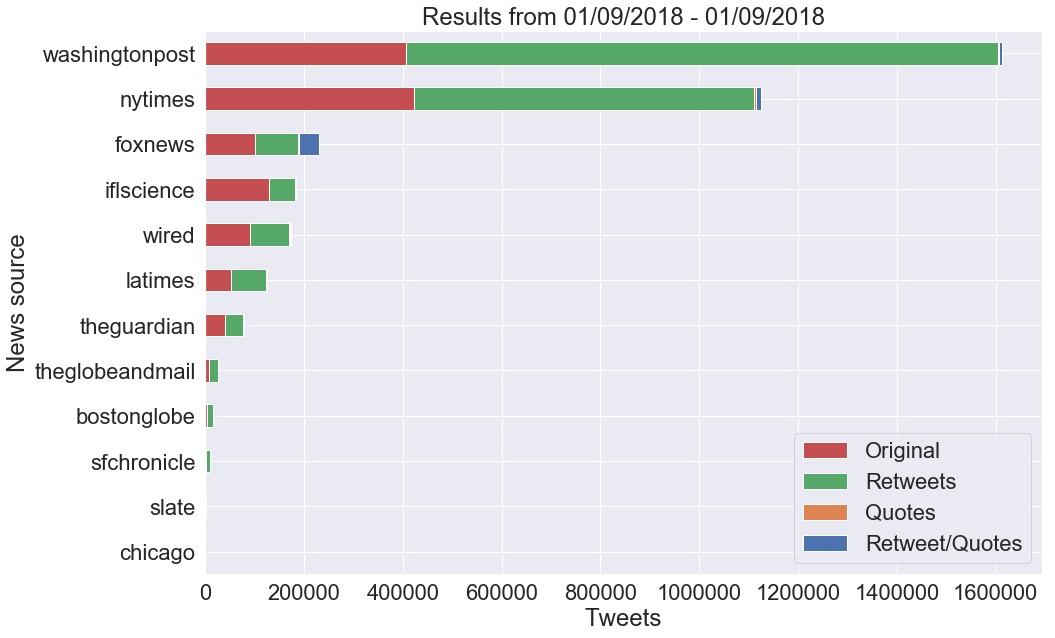

In [65]:
colors = itertools.cycle(sns.color_palette())

order = x['found tweets'].sort_values().index

# RT Quotes
df = x.original + x.retweets + x.quotes + x['retweets/quotes']
df.reindex(order).plot(kind="barh", color=next(colors), label="Retweet/Quotes")

# Quoted
df = x.original + x.retweets + x.quotes
df.reindex(order).plot(kind="barh", color=next(colors), label="Quotes")

# Retweets
df = x.original + x.retweets
df.reindex(order).plot(kind="barh", color=next(colors), label="Retweets")

# Originals
df = x.original
df.reindex(order).plot(kind="barh", color=next(colors), label="Original")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc="lower right")
plt.ylabel("News source");
plt.xlabel("Tweets");
plt.title("Results from 01/09/2018 - 01/09/2018");
# plt.xscale("log")

## Retweets/Quotes

In [20]:
total_rts = tweets.retweeted_status.notna().sum()

rts = set(tweets.retweeted_status.dropna().unique())
orig_tweets = tweets.retweeted_status.nunique()

found_rts = len(rts.intersection(set(tweets.tweet_id)))

s = """The data contains {} ({:.2f}%) retweets which in total reference {} ({:.2f}%) original tweets.
Of these {} original tweets, we find {} ({:.2f}%) in our collection."""

print(s.format(total_rts, 100*total_rts/t,
               orig_tweets, 100*orig_tweets/t,
               orig_tweets, found_rts, 100*found_rts/orig_tweets))

The data contains 2312617 (64.41%) retweets which in total reference 203116 (5.66%) original tweets.
Of these 203116 original tweets, we find 119317 (58.74%) in our collection.


In [89]:
total_rts = tweets.quoted_status.notna().sum()

rts = set(tweets.quoted_status.dropna().unique())
orig_tweets = tweets.quoted_status.nunique()

found_rts = len(rts.intersection(set(tweets.tweet_id)))

s = """The data contains {} ({:.2f}%) quotes which in total reference {} ({:.2f}%) original tweets.
Of these {} original tweets, we find {} ({:.2f}%) in our collection."""

print(s.format(total_rts, 100*total_rts/t,
               orig_tweets, 100*orig_tweets/t,
               orig_tweets, found_rts, 100*found_rts/orig_tweets))

The data contains 73577 (2.05%) quotes which in total reference 9025 (0.25%) original tweets.
Of these 9025 original tweets, we find 1589 (17.61%) in our collection.


In [66]:
values = []
values.append(x.sum().original)
values.append(x.sum().retweets + x.sum()['retweets/quotes'])
values.append(x.sum().quotes + x.sum()['retweets/quotes'])

rel_ids = set(originals.tweet_id)
a = len(set(tweets.tweet_id).intersection(rel_ids))
values.append(a)
values.append(len(rel_ids)-a)

rel_ids = set(retweets.retweeted_status).union(rtquotes.retweeted_status)
a = len(set(tweets.tweet_id).intersection(rel_ids))
values.append(a)
values.append(len(rel_ids)-a)

rel_ids = set(quotes.quoted_status).union(rtquotes.quoted_status)
a = len(set(tweets.tweet_id).intersection(rel_ids))
values.append(a)
values.append(len(rel_ids)-a)

In [67]:
data = dict(
    type='sankey',
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label = ["All tweets", "Original", "Retweets", "Quotes", "Found", "Missing"]
    ),
    link = dict(
      source = [0, 0, 0, 1, 1, 2, 2, 3, 3],
      target = [1, 2, 3, 4, 5, 4, 5, 4, 5],
      value = values
  ))

layout =  dict(
    title = "Retweets/Quotes pointing outside of the dataset",
    font = dict(
      size = 20
    )
)

fig = dict(data=[data], layout=layout)
py.iplot(fig, validate=False)